# Portfolio Hedging Strategy Simulation

This notebook simulates various put option hedging strategies across three major market crashes:

1. **Dot-Com Bubble (1999-2003)**: Slow, multi-year decline
2. **Global Financial Crisis (2007-2009)**: Deep systemic crash
3. **COVID-19 Crash (2019-2021)**: Fastest crash in history

## Data Requirements

This notebook uses **real WRDS market data** (26 years: 1999-2025) including:
- S&P 500 index prices
- VIX volatility index
- 3-month Treasury rates
- SPX option prices (22.4M rows)

**Setup**:
```bash
# Download encrypted data from GitHub Release
python scripts/download_release_data.py

# Set decryption key
export WRDS_DATA_KEY="<provided-separately>"
```

See `WRDS_QUICK_START.md` for full setup instructions.

In [1]:
# Setup: Import libraries and define simulation framework
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent
sys.path.insert(0, str(project_root / "src"))

# Force reload of modules to pick up latest changes
import importlib

if "options_hedge" in sys.modules:
    import options_hedge.analyzer
    import options_hedge.fixed_floor_lp
    import options_hedge.strategies
    import options_hedge.vix_floor_lp

    importlib.reload(options_hedge.fixed_floor_lp)
    importlib.reload(options_hedge.vix_floor_lp)
    importlib.reload(options_hedge.strategies)
    importlib.reload(options_hedge.analyzer)


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from options_hedge.analyzer import PortfolioAnalyzer
from options_hedge.market import Market
from options_hedge.portfolio import Portfolio
from options_hedge.simulation import run_simulation
from options_hedge.strategies import (
    conditional_hedging_strategy,
    fixed_floor_lp_strategy,
    quarterly_protective_put_strategy,
    vix_ladder_strategy,
)

# Simulation parameters
initial_value = 1_000_000  # $1M starting portfolio

In [2]:
# Load environment variables from .env file (for local development)
# This allows VS Code's Jupyter extension to access WRDS_DATA_KEY
# Create a .env file in the project root with: WRDS_DATA_KEY=your-key-here
import os
from pathlib import Path

# Try to load from .env file if it exists
env_file = project_root / ".env"
if env_file.exists():
    from dotenv import load_dotenv

    load_dotenv(env_file)
    print("✓ Loaded environment variables from .env file")
else:
    print("⚠️  No .env file found. Set WRDS_DATA_KEY manually or create .env file")
    print("   See .env.example for template")

# Verify key is available
if os.getenv("WRDS_DATA_KEY"):
    print("✓ WRDS_DATA_KEY is set")
else:
    print("❌ WRDS_DATA_KEY not found - notebook will use Yahoo Finance fallback")

✓ Loaded environment variables from .env file
✓ WRDS_DATA_KEY is set


## 📊 Portfolio Evaluation Metrics

We'll use these metrics to compare strategies:
1. **Beta (β)**: Systematic risk - $\beta = \frac{\text{Cov}(R_p, R_m)}{\text{Var}(R_m)}$
2. **Upside/Downside Capture**: Performance in up/down markets
3. **Sortino Ratio**: Risk-adjusted return using downside deviation - $\text{Sortino} = \frac{R_p - R_f}{\sigma_{\text{downside}}}$
4. **Calmar Ratio**: Return vs maximum drawdown - $\text{Calmar} = \frac{\text{Annualized Return}}{\text{Max Drawdown}}$

In [3]:
# Dot-Com Bubble (1999-2003): Slow crash over 3+ years
# Using WRDS real market data with VIX and Treasury rates
market_dotcom = Market(start="1999-01-01", end="2003-12-31", use_wrds=True)

portfolio_unhedged_dc = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_quarterly_dc = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_conditional_dc = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_ladder_dc = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_fixed_floor_dc = Portfolio(initial_value=initial_value, beta=1.0)

results_unhedged_dc = run_simulation(
    market_dotcom, portfolio_unhedged_dc, lambda p, price, date, params, m: None, {}
)

# Quarterly: Buy protective puts every 90 days (default is good)
quarterly_params_dc = {
    "hedge_interval": 90,  # Quarterly rebalancing
    "expiry_days": 90,  # 90-day expiry
}
results_quarterly_dc = run_simulation(
    market_dotcom,
    portfolio_quarterly_dc,
    quarterly_protective_put_strategy,
    quarterly_params_dc,
)

# Conditional: Only hedge on SEVERE triggers (much tighter thresholds)
conditional_params_dc = {
    "drop_threshold": -0.10,  # Only trigger on 10%+ drawdown (was -5%)
    "vol_multiplier": 2.0,  # Only trigger when vol doubles (was 1.5x)
    "expiry_days": 90,
}
results_conditional_dc = run_simulation(
    market_dotcom,
    portfolio_conditional_dc,
    conditional_hedging_strategy,
    conditional_params_dc,
)

# Calculate realistic scenario returns based on historical volatility
returns_dc = market_dotcom.data["Returns"]
daily_vol_dc = returns_dc.std()
ann_vol_dc = daily_vol_dc * np.sqrt(252)

# Scenarios: 2-sigma crash, 1-sigma mild, 1-sigma up (annualized)
scenario_returns_dc = {
    "crash": -2.0 * ann_vol_dc,  # 2-sigma downside
    "mild": -1.0 * ann_vol_dc,  # 1-sigma downside
    "up": 1.0 * ann_vol_dc,  # 1-sigma upside
}

# VIX Ladder: Monthly rebalancing (like JEPI/HELO), better protection allocation
ladder_params_dc = {
    "hedge_interval": 30,  # Monthly (was 7 days - way too frequent!)
    "expiry_days": 90,
    "alpha": 0.05,
    "ladder_budget_allocations": [
        (0.05, 0.15, 0.30),  # Near: 5-15% OTM, 30% (was 5%)
        (0.15, 0.25, 0.35),  # Mid: 15-25% OTM, 35% (was 15%)
        (0.25, 0.40, 0.25),  # Far: 25-40% OTM, 25% (was 30%)
        (0.40, 1.00, 0.10),  # Deep: 40%+ OTM, 10% (was 50%!)
    ],
    "strike_density": 0.05,
    "transaction_cost_rate": 0.01,  # 1% institutional (was 5%)
}
results_ladder_dc = run_simulation(
    market_dotcom, portfolio_ladder_dc, vix_ladder_strategy, ladder_params_dc
)

fixed_floor_params_dc = {
    "floor_ratio": 0.20,
    "hedge_interval": 7,
    "expiry_days": 90,
    "scenario_returns": scenario_returns_dc,
}
results_fixed_floor_dc = run_simulation(
    market_dotcom,
    portfolio_fixed_floor_dc,
    fixed_floor_lp_strategy,
    fixed_floor_params_dc,
)

print(
    f"Dotcom: Unhedged {results_unhedged_dc['Value'].iloc[-1]:,.0f} | Quarterly {results_quarterly_dc['Value'].iloc[-1]:,.0f} | Conditional {results_conditional_dc['Value'].iloc[-1]:,.0f} | VIX-Ladder {results_ladder_dc['Value'].iloc[-1]:,.0f} | Fixed Floor {results_fixed_floor_dc['Value'].iloc[-1]:,.0f}"
)

/Users/akhilkarra/ode/21393/options-hedge/src/options_hedge/wrds_data.py:371: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(io.BytesIO(decompressed))
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Set parameter Username
Set parameter LicenseID to value 2620852
Academic license - for non-commercial use only - expires 2026-02-11
Dotcom: Unhedged 903,542 | Quarterly 750,172 | Conditional 867,998 | VIX-Ladder 905,581 | Fixed Floor 903,542


In [4]:
# Global Financial Crisis (2007-2009): Deep financial crisis
# Using WRDS real market data with VIX and Treasury rates
market_gfc = Market(start="2007-01-01", end="2009-12-31", use_wrds=True)

portfolio_unhedged_gfc = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_quarterly_gfc = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_conditional_gfc = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_ladder_gfc = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_fixed_floor_gfc = Portfolio(initial_value=initial_value, beta=1.0)

results_unhedged_gfc = run_simulation(
    market_gfc, portfolio_unhedged_gfc, lambda p, price, date, params, m: None, {}
)

quarterly_params_gfc = {
    "hedge_interval": 90,
    "expiry_days": 90,
}
results_quarterly_gfc = run_simulation(
    market_gfc,
    portfolio_quarterly_gfc,
    quarterly_protective_put_strategy,
    quarterly_params_gfc,
)

conditional_params_gfc = {
    "drop_threshold": -0.10,
    "vol_multiplier": 2.0,
    "expiry_days": 90,
}
results_conditional_gfc = run_simulation(
    market_gfc,
    portfolio_conditional_gfc,
    conditional_hedging_strategy,
    conditional_params_gfc,
)

# Calculate realistic scenario returns based on GFC historical volatility
returns_gfc = market_gfc.data["Returns"]
daily_vol_gfc = returns_gfc.std()
ann_vol_gfc = daily_vol_gfc * np.sqrt(252)

scenario_returns_gfc = {
    "crash": -2.0 * ann_vol_gfc,  # 2-sigma downside
    "mild": -1.0 * ann_vol_gfc,  # 1-sigma downside
    "up": 1.0 * ann_vol_gfc,  # 1-sigma upside
}

ladder_params_gfc = {
    "hedge_interval": 30,
    "expiry_days": 90,
    "alpha": 0.05,
    "ladder_budget_allocations": [
        (0.05, 0.15, 0.30),
        (0.15, 0.25, 0.35),
        (0.25, 0.40, 0.25),
        (0.40, 1.00, 0.10),
    ],
    "strike_density": 0.05,
    "transaction_cost_rate": 0.01,
}
results_ladder_gfc = run_simulation(
    market_gfc, portfolio_ladder_gfc, vix_ladder_strategy, ladder_params_gfc
)

fixed_floor_params_gfc = {
    "floor_ratio": 0.20,
    "hedge_interval": 7,
    "expiry_days": 90,
    "scenario_returns": scenario_returns_gfc,
}
results_fixed_floor_gfc = run_simulation(
    market_gfc,
    portfolio_fixed_floor_gfc,
    fixed_floor_lp_strategy,
    fixed_floor_params_gfc,
)

print(
    f"GFC: Unhedged {results_unhedged_gfc['Value'].iloc[-1]:,.0f} | Quarterly {results_quarterly_gfc['Value'].iloc[-1]:,.0f} | Conditional {results_conditional_gfc['Value'].iloc[-1]:,.0f} | VIX-Ladder {results_ladder_gfc['Value'].iloc[-1]:,.0f} | Fixed Floor {results_fixed_floor_gfc['Value'].iloc[-1]:,.0f}"
)

/Users/akhilkarra/ode/21393/options-hedge/src/options_hedge/wrds_data.py:371: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(io.BytesIO(decompressed))
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


GFC: Unhedged 795,157 | Quarterly 710,620 | Conditional 760,760 | VIX-Ladder 797,131 | Fixed Floor 795,157


In [5]:
# COVID-19 Crash (2019-2021): Fastest crash in history
# Using WRDS real market data with VIX and Treasury rates
market_covid = Market(start="2019-06-01", end="2021-06-30", use_wrds=True)

portfolio_unhedged_covid = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_quarterly_covid = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_conditional_covid = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_ladder_covid = Portfolio(initial_value=initial_value, beta=1.0)
portfolio_fixed_floor_covid = Portfolio(initial_value=initial_value, beta=1.0)

results_unhedged_covid = run_simulation(
    market_covid, portfolio_unhedged_covid, lambda p, price, date, params, m: None, {}
)

quarterly_params_covid = {
    "hedge_interval": 90,
    "expiry_days": 90,
}
results_quarterly_covid = run_simulation(
    market_covid,
    portfolio_quarterly_covid,
    quarterly_protective_put_strategy,
    quarterly_params_covid,
)

conditional_params_covid = {
    "drop_threshold": -0.10,
    "vol_multiplier": 2.0,
    "expiry_days": 90,
}
results_conditional_covid = run_simulation(
    market_covid,
    portfolio_conditional_covid,
    conditional_hedging_strategy,
    conditional_params_covid,
)

# Calculate realistic scenario returns based on COVID historical volatility
returns_covid = market_covid.data["Returns"]
daily_vol_covid = returns_covid.std()
ann_vol_covid = daily_vol_covid * np.sqrt(252)

scenario_returns_covid = {
    "crash": -2.0 * ann_vol_covid,  # 2-sigma downside
    "mild": -1.0 * ann_vol_covid,  # 1-sigma downside
    "up": 1.0 * ann_vol_covid,  # 1-sigma upside
}

ladder_params_covid = {
    "hedge_interval": 30,
    "expiry_days": 90,
    "alpha": 0.05,
    "ladder_budget_allocations": [
        (0.05, 0.15, 0.30),
        (0.15, 0.25, 0.35),
        (0.25, 0.40, 0.25),
        (0.40, 1.00, 0.10),
    ],
    "strike_density": 0.05,
    "transaction_cost_rate": 0.01,
}
results_ladder_covid = run_simulation(
    market_covid, portfolio_ladder_covid, vix_ladder_strategy, ladder_params_covid
)

fixed_floor_params_covid = {
    "floor_ratio": 0.20,
    "hedge_interval": 7,
    "expiry_days": 90,
    "scenario_returns": scenario_returns_covid,
}
results_fixed_floor_covid = run_simulation(
    market_covid,
    portfolio_fixed_floor_covid,
    fixed_floor_lp_strategy,
    fixed_floor_params_covid,
)

print(
    f"COVID: Unhedged {results_unhedged_covid['Value'].iloc[-1]:,.0f} | Quarterly {results_quarterly_covid['Value'].iloc[-1]:,.0f} | Conditional {results_conditional_covid['Value'].iloc[-1]:,.0f} | VIX-Ladder {results_ladder_covid['Value'].iloc[-1]:,.0f} | Fixed Floor {results_fixed_floor_covid['Value'].iloc[-1]:,.0f}"
)

/Users/akhilkarra/ode/21393/options-hedge/src/options_hedge/wrds_data.py:371: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(io.BytesIO(decompressed))
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


COVID: Unhedged 1,563,811 | Quarterly 1,486,512 | Conditional 1,552,038 | VIX-Ladder 1,543,528 | Fixed Floor 1,563,811


## 📈 Portfolio Performance Over Time

Visual comparison of all hedging strategies across the three market crashes.

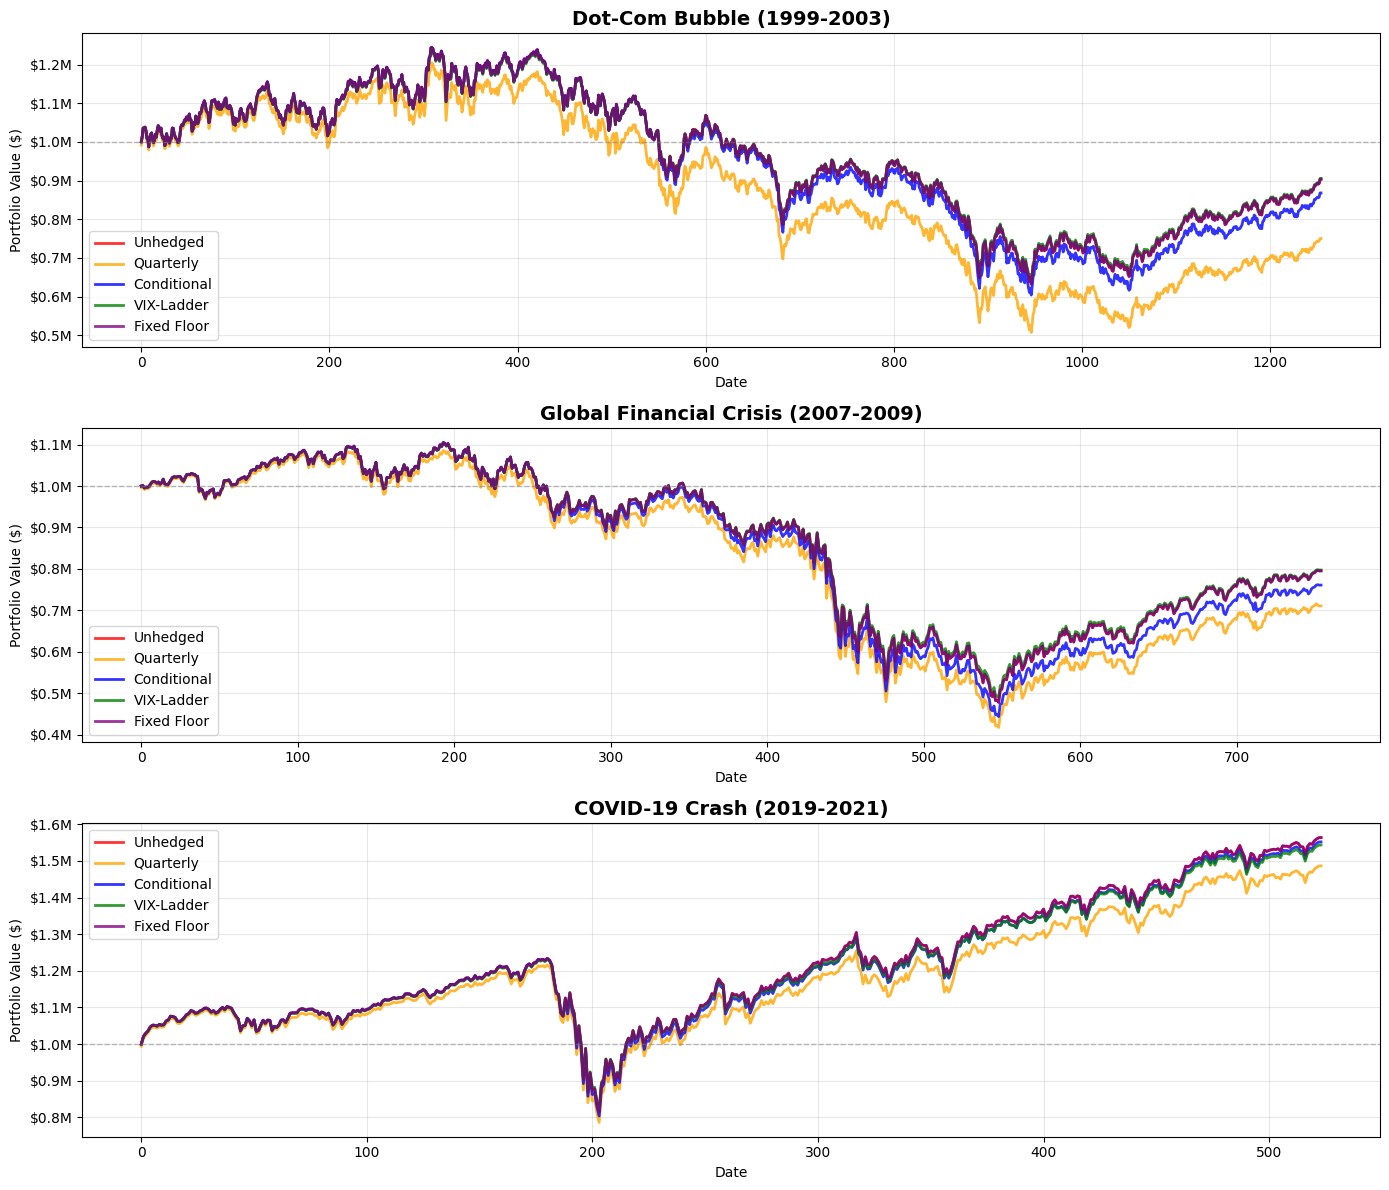

In [6]:
# Plot portfolio values over time for all three crashes
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

crashes_data = [
    (
        "Dot-Com Bubble (1999-2003)",
        results_unhedged_dc,
        results_quarterly_dc,
        results_conditional_dc,
        results_ladder_dc,
        results_fixed_floor_dc,
    ),
    (
        "Global Financial Crisis (2007-2009)",
        results_unhedged_gfc,
        results_quarterly_gfc,
        results_conditional_gfc,
        results_ladder_gfc,
        results_fixed_floor_gfc,
    ),
    (
        "COVID-19 Crash (2019-2021)",
        results_unhedged_covid,
        results_quarterly_covid,
        results_conditional_covid,
        results_ladder_covid,
        results_fixed_floor_covid,
    ),
]

colors = {
    "Unhedged": "red",
    "Quarterly": "orange",
    "Conditional": "blue",
    "VIX-Ladder": "green",
    "Fixed Floor": "purple",
}

for ax, (crash_name, unhedged, quarterly, conditional, ladder, fixed_floor) in zip(
    axes, crashes_data
):
    # Plot each strategy
    ax.plot(
        unhedged.index,
        unhedged["Value"],
        label="Unhedged",
        color=colors["Unhedged"],
        linewidth=2,
        alpha=0.8,
    )
    ax.plot(
        quarterly.index,
        quarterly["Value"],
        label="Quarterly",
        color=colors["Quarterly"],
        linewidth=2,
        alpha=0.8,
    )
    ax.plot(
        conditional.index,
        conditional["Value"],
        label="Conditional",
        color=colors["Conditional"],
        linewidth=2,
        alpha=0.8,
    )
    ax.plot(
        ladder.index,
        ladder["Value"],
        label="VIX-Ladder",
        color=colors["VIX-Ladder"],
        linewidth=2,
        alpha=0.8,
    )
    ax.plot(
        fixed_floor.index,
        fixed_floor["Value"],
        label="Fixed Floor",
        color=colors["Fixed Floor"],
        linewidth=2,
        alpha=0.8,
    )

    # Format
    ax.set_title(crash_name, fontsize=14, fontweight="bold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio Value ($)")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)
    ax.axhline(y=initial_value, color="gray", linestyle="--", linewidth=1, alpha=0.5)

    # Format y-axis as currency
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x / 1e6:.1f}M"))

plt.tight_layout()
plt.show()

## 🎯 Final Analysis: Comparing LP Strategies

### LP Strategy Comparison
We're comparing two LP-based portfolio insurance approaches:

1. **VIX-Ladder LP**: VIX-responsive budgeting with strike ladder diversification
2. **Fixed Floor LP**: Minimize cost subject to floor constraint (guarantees max 20% loss)

In [7]:
# Define comprehensive analysis function (returns DataFrame, no prints)
def comprehensive_analysis(results_dict, crash_name):
    """Analyze multiple strategies and return metrics DataFrame."""
    metrics = {}

    for strategy_name, results in results_dict.items():
        values = results["Value"]
        returns = values.pct_change().dropna()

        # Core metrics
        total_return = (values.iloc[-1] / values.iloc[0] - 1) * 100
        ann_return = (
            (values.iloc[-1] / values.iloc[0]) ** (252 / len(values)) - 1
        ) * 100

        # Risk metrics
        daily_vol = returns.std() * np.sqrt(252) * 100
        max_dd = (
            (values - values.expanding(min_periods=1).max())
            / values.expanding(min_periods=1).max()
        ).min() * 100

        # Downside metrics
        downside_returns = returns[returns < 0]
        downside_vol = (
            downside_returns.std() * np.sqrt(252) * 100
            if len(downside_returns) > 0
            else 0
        )

        # Sharpe (0% risk-free rate)
        sharpe = ann_return / daily_vol if daily_vol != 0 else 0

        # Sortino (0% risk-free rate)
        sortino = ann_return / downside_vol if downside_vol != 0 else 0

        # Calmar ratio
        calmar = ann_return / abs(max_dd) if max_dd != 0 else 0

        metrics[strategy_name] = {
            "Total Return (%)": total_return,
            "Ann. Return (%)": ann_return,
            "Daily Vol (%)": daily_vol,
            "Max Drawdown (%)": max_dd,
            "Sharpe": sharpe,
            "Sortino": sortino,
            "Calmar": calmar,
            "Downside Vol (%)": downside_vol,
            "Final Value ($)": values.iloc[-1],
        }

    # Return DataFrame only (no prints for published output)
    df = pd.DataFrame(metrics).T
    return df

In [8]:
# Run analysis for each crash period (returns DataFrames)
dc_analysis = comprehensive_analysis(
    {
        "Unhedged": results_unhedged_dc,
        "Quarterly": results_quarterly_dc,
        "Conditional": results_conditional_dc,
        "VIX-Ladder": results_ladder_dc,
        "Fixed Floor": results_fixed_floor_dc,
    },
    "Dot-Com Crash",
)

gfc_analysis = comprehensive_analysis(
    {
        "Unhedged": results_unhedged_gfc,
        "Quarterly": results_quarterly_gfc,
        "Conditional": results_conditional_gfc,
        "VIX-Ladder": results_ladder_gfc,
        "Fixed Floor": results_fixed_floor_gfc,
    },
    "Global Financial Crisis",
)

covid_analysis = comprehensive_analysis(
    {
        "Unhedged": results_unhedged_covid,
        "Quarterly": results_quarterly_covid,
        "Conditional": results_conditional_covid,
        "VIX-Ladder": results_ladder_covid,
        "Fixed Floor": results_fixed_floor_covid,
    },
    "COVID-19",
)

# Display results tables
display(dc_analysis)
display(gfc_analysis)
display(covid_analysis)

,Total Return (%),Ann. Return (%),Daily Vol (%),Max Drawdown (%),Sharpe,Sortino,Calmar,Downside Vol (%),Final Value ($)
Unhedged,-9.645791,-2.016133,21.246367,-49.146948,-0.094893,-0.153133,-0.041023,13.165888,903542.086725
Quarterly,-24.363612,-5.452614,23.954596,-57.855281,-0.227623,-0.363823,-0.094246,14.986998,750171.608711
Conditional,-13.200162,-2.802567,21.795555,-51.426513,-0.128584,-0.204550,-0.054497,13.701119,867998.380136
VIX-Ladder,-9.441933,-1.971782,20.816966,-48.421701,-0.094720,-0.152869,-0.040721,12.898529,905580.667552
Fixed Floor,-9.645791,-2.016133,21.246367,-49.146948,-0.094893,-0.153133,-0.041023,13.165888,903542.086725


,Total Return (%),Ann. Return (%),Daily Vol (%),Max Drawdown (%),Sharpe,Sortino,Calmar,Downside Vol (%),Final Value ($)
Unhedged,-20.484254,-7.365286,29.957051,-56.775388,-0.245862,-0.313795,-0.129727,23.471645,795157.463898
Quarterly,-28.669283,-10.663812,32.634022,-61.585452,-0.326770,-0.413347,-0.173155,25.798713,710620.473009
Conditional,-23.923986,-8.722552,31.087612,-59.886346,-0.280580,-0.356534,-0.145652,24.464858,760760.141856
VIX-Ladder,-20.286920,-7.288618,29.002625,-55.712300,-0.251309,-0.320803,-0.130826,22.719902,797130.795230
Fixed Floor,-20.484254,-7.365286,29.957051,-56.775388,-0.245862,-0.313795,-0.129727,23.471645,795157.463898


,Total Return (%),Ann. Return (%),Daily Vol (%),Max Drawdown (%),Sharpe,Sortino,Calmar,Downside Vol (%),Final Value ($)
Unhedged,56.381056,23.989888,25.654257,-33.924960,0.935123,1.019567,0.707146,23.529484,1.563811e+06
Quarterly,49.533448,21.348517,26.375404,-35.354878,0.809410,0.885214,0.603835,24.116789,1.486512e+06
Conditional,55.203837,23.540129,25.807892,-34.847535,0.912129,0.991050,0.675518,23.752717,1.552038e+06
VIX-Ladder,54.352808,23.213888,24.871747,-33.225181,0.933344,1.016499,0.698684,22.837093,1.543528e+06
Fixed Floor,56.381056,23.989888,25.654257,-33.924960,0.935123,1.019567,0.707146,23.529484,1.563811e+06


## 📈 Quantitative Performance Metrics

Now let's analyze each crash using industry-standard metrics:
- **Beta**: Systematic risk vs market
- **Upside/Downside Capture**: Performance asymmetry
- **Sortino Ratio**: Risk-adjusted return (downside focus)
- **Calmar Ratio**: Return per unit of max drawdown

In [9]:
# Prepare data for PortfolioAnalyzer (needs DataFrame with Date column)
def create_analyzer_df(
    results_unhedged,
    results_quarterly,
    results_conditional,
    results_ladder,
    results_fixed_floor,
):
    """Merge strategy results into single DataFrame for analyzer."""
    df = pd.DataFrame(
        {
            "Date": results_unhedged.index,
            "Market": results_unhedged["Value"].values,
            "Unhedged": results_unhedged["Value"].values,
            "Quarterly": results_quarterly["Value"].values,
            "Conditional": results_conditional["Value"].values,
            "VIX-Ladder": results_ladder["Value"].values,
            "Fixed Floor": results_fixed_floor["Value"].values,
        }
    )
    return df


# Create analyzer DataFrames for each crash
dc_metrics_df = create_analyzer_df(
    results_unhedged_dc,
    results_quarterly_dc,
    results_conditional_dc,
    results_ladder_dc,
    results_fixed_floor_dc,
)
gfc_metrics_df = create_analyzer_df(
    results_unhedged_gfc,
    results_quarterly_gfc,
    results_conditional_gfc,
    results_ladder_gfc,
    results_fixed_floor_gfc,
)
covid_metrics_df = create_analyzer_df(
    results_unhedged_covid,
    results_quarterly_covid,
    results_conditional_covid,
    results_ladder_covid,
    results_fixed_floor_covid,
)

# Create analyzers (benchmark_col not benchmark_column!)
dc_analyzer = PortfolioAnalyzer(dc_metrics_df, benchmark_col="Market")
gfc_analyzer = PortfolioAnalyzer(gfc_metrics_df, benchmark_col="Market")
covid_analyzer = PortfolioAnalyzer(covid_metrics_df, benchmark_col="Market")

In [10]:
# Display comprehensive metric summaries
display(dc_analyzer.get_summary())
display(gfc_analyzer.get_summary())
display(covid_analyzer.get_summary())

,Total Return (%),Beta,Up Capture (%),Down Capture (%),Sortino Ratio,Calmar Ratio
Strategy,,,,,,
Market,-9.65,1.00,100.0,100.0,-0.15,-0.04
Unhedged,-9.65,1.00,100.0,100.0,-0.15,-0.04
Quarterly,-24.36,1.12,110.6,112.9,-0.36,-0.09
Conditional,-13.20,1.02,101.9,102.5,-0.20,-0.05
VIX-Ladder,-9.44,0.98,98.0,98.0,-0.15,-0.04
Fixed Floor,-9.65,1.00,100.0,100.0,-0.15,-0.04


,Total Return (%),Beta,Up Capture (%),Down Capture (%),Sortino Ratio,Calmar Ratio
Strategy,,,,,,
Market,-20.48,1.00,100.0,100.0,-0.31,-0.13
Unhedged,-20.48,1.00,100.0,100.0,-0.31,-0.13
Quarterly,-28.67,1.09,106.4,108.0,-0.41,-0.17
Conditional,-23.92,1.04,103.0,103.7,-0.36,-0.15
VIX-Ladder,-20.29,0.97,97.1,97.3,-0.32,-0.13
Fixed Floor,-20.48,1.00,100.0,100.0,-0.31,-0.13


,Total Return (%),Beta,Up Capture (%),Down Capture (%),Sortino Ratio,Calmar Ratio
Strategy,,,,,,
Market,56.38,1.00,100.0,100.0,1.02,0.71
Unhedged,56.38,1.00,100.0,100.0,1.02,0.71
Quarterly,49.53,1.03,102.1,104.4,0.89,0.60
Conditional,55.20,1.01,100.4,100.8,0.99,0.68
VIX-Ladder,54.35,0.97,97.3,97.4,1.02,0.70
Fixed Floor,56.38,1.00,100.0,100.0,1.02,0.71


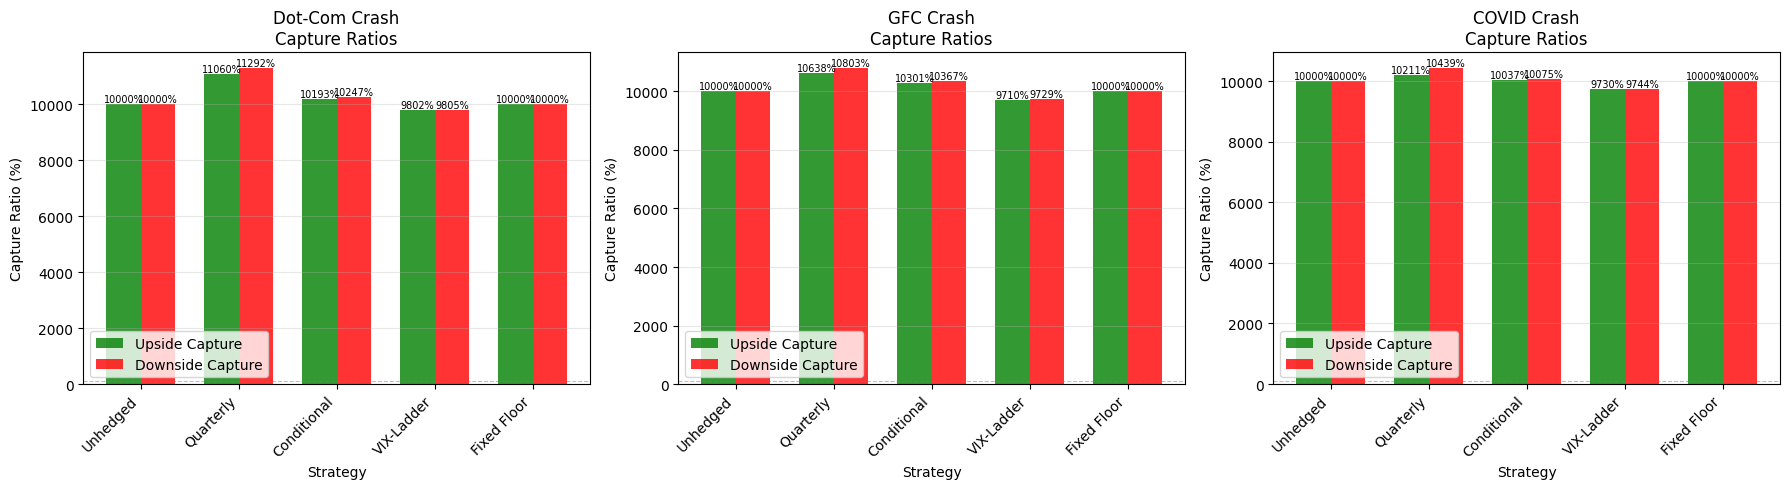


📊 Interpretation:
• Lower downside capture = better protection during market crashes
• Both LP strategies should show significantly lower downside capture than unhedged
• Fixed Floor LP targets specific floor (80% of initial value)


In [11]:
# Visualize Capture Ratios across crashes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
crashes = [("Dot-Com", dc_analyzer), ("GFC", gfc_analyzer), ("COVID", covid_analyzer)]
strategies = ["Unhedged", "Quarterly", "Conditional", "VIX-Ladder", "Fixed Floor"]

for ax, (crash_name, analyzer) in zip(axes, crashes):
    upside_ratios = []
    downside_ratios = []

    for strategy in strategies:
        upside, downside = analyzer.calculate_capture_ratios(strategy)
        upside_ratios.append(upside * 100)  # Convert to percentage
        downside_ratios.append(downside * 100)

    x = np.arange(len(strategies))
    width = 0.35

    bars1 = ax.bar(
        x - width / 2,
        upside_ratios,
        width,
        label="Upside Capture",
        alpha=0.8,
        color="green",
    )
    bars2 = ax.bar(
        x + width / 2,
        downside_ratios,
        width,
        label="Downside Capture",
        alpha=0.8,
        color="red",
    )

    ax.set_xlabel("Strategy")
    ax.set_ylabel("Capture Ratio (%)")
    ax.set_title(f"{crash_name} Crash\nCapture Ratios")
    ax.set_xticks(x)
    ax.set_xticklabels(strategies, rotation=45, ha="right")
    ax.axhline(y=100, color="gray", linestyle="--", linewidth=0.8, alpha=0.5)
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{height:.0f}%",
                ha="center",
                va="bottom",
                fontsize=7,
            )

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("• Lower downside capture = better protection during market crashes")
print(
    "• Both LP strategies should show significantly lower downside capture than unhedged"
)
print("• Fixed Floor LP targets specific floor (80% of initial value)")

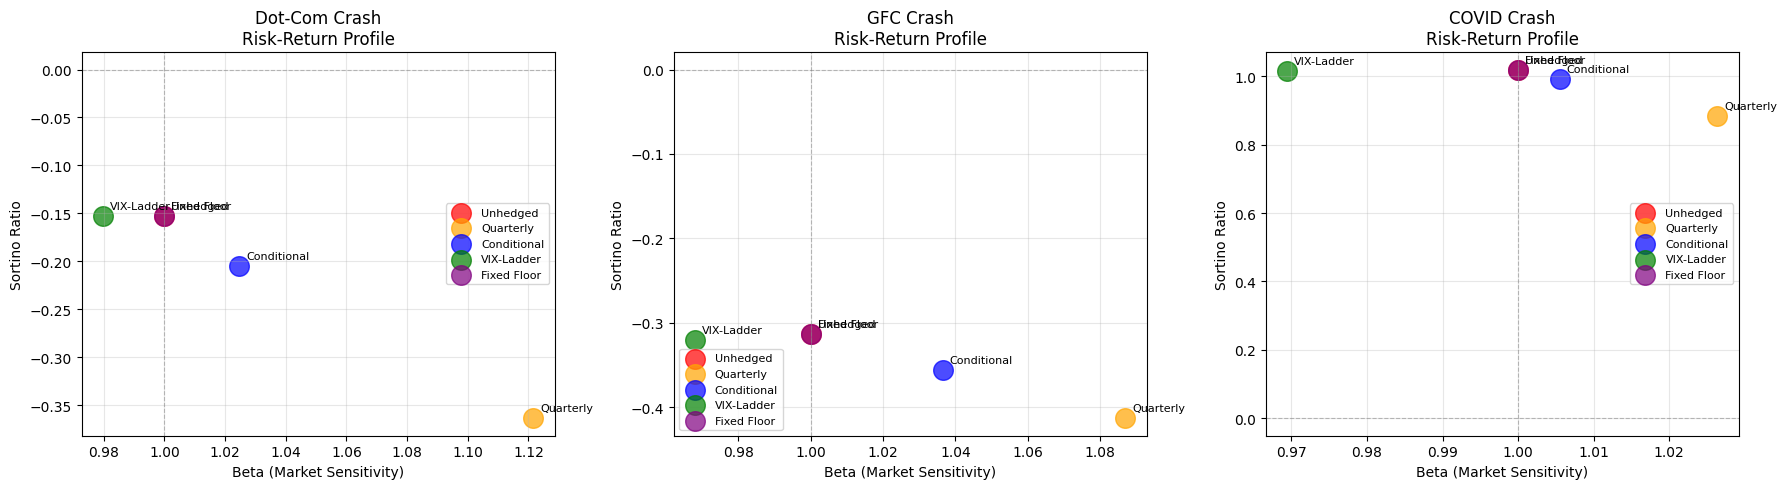


📊 Interpretation:
• Higher Sortino = better risk-adjusted returns (downside focus)
• Lower Beta = less market sensitivity during crashes
• Best performers: high Sortino + low Beta (upper-left quadrant)
• Fixed Floor LP optimizes for floor constraint rather than VIX response


In [12]:
# Risk-Adjusted Returns: Sortino vs Beta scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (crash_name, analyzer) in zip(axes, crashes):
    betas = []
    sortinos = []

    for strategy in strategies:
        beta = analyzer.calculate_beta(strategy)
        sortino = analyzer.calculate_sortino(strategy)
        betas.append(beta)
        sortinos.append(sortino)

    colors = ["red", "orange", "blue", "green", "purple"]
    for i, (strategy, beta, sortino) in enumerate(zip(strategies, betas, sortinos)):
        ax.scatter(beta, sortino, s=200, alpha=0.7, color=colors[i], label=strategy)
        ax.annotate(
            strategy,
            (beta, sortino),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
        )

    ax.set_xlabel("Beta (Market Sensitivity)")
    ax.set_ylabel("Sortino Ratio")
    ax.set_title(f"{crash_name} Crash\nRisk-Return Profile")
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.5)
    ax.axvline(x=1.0, color="gray", linestyle="--", linewidth=0.8, alpha=0.5)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("• Higher Sortino = better risk-adjusted returns (downside focus)")
print("• Lower Beta = less market sensitivity during crashes")
print("• Best performers: high Sortino + low Beta (upper-left quadrant)")
print("• Fixed Floor LP optimizes for floor constraint rather than VIX response")

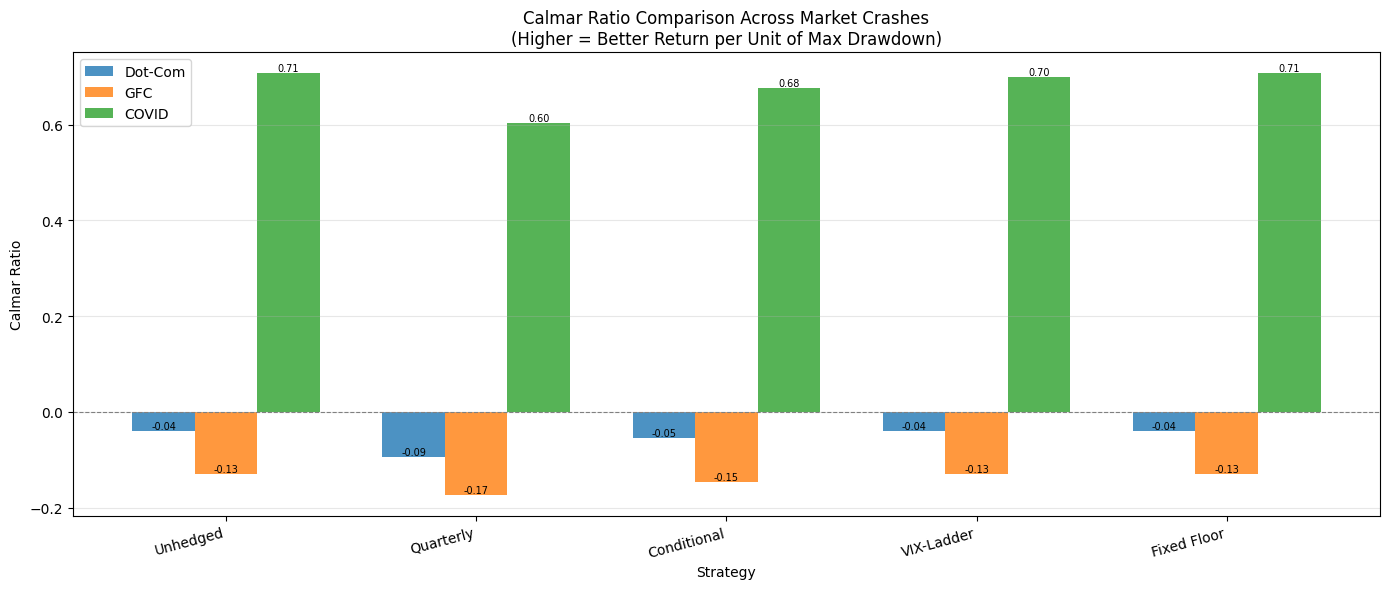


📊 Key Insights:
• Calmar Ratio = CAGR / |Max Drawdown|
• Higher values = better return relative to worst drawdown
• Negative values = negative returns during crash period
• Fixed Floor LP targets 20% max loss (80% floor) vs VIX-Ladder's adaptive budget


In [13]:
# Calmar Ratio Comparison (Return per unit of max drawdown)
fig, ax = plt.subplots(figsize=(14, 6))

crash_names = ["Dot-Com", "GFC", "COVID"]
x = np.arange(len(strategies))
width = 0.25

for i, (crash_name, analyzer) in enumerate(crashes):
    calmars = [analyzer.calculate_calmar(strategy) for strategy in strategies]
    offset = (i - 1) * width
    bars = ax.bar(x + offset, calmars, width, label=crash_name, alpha=0.8)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=7,
        )

ax.set_xlabel("Strategy")
ax.set_ylabel("Calmar Ratio")
ax.set_title(
    "Calmar Ratio Comparison Across Market Crashes\n(Higher = Better Return per Unit of Max Drawdown)"
)
ax.set_xticks(x)
ax.set_xticklabels(strategies, rotation=15, ha="right")
ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Insights:")
print("• Calmar Ratio = CAGR / |Max Drawdown|")
print("• Higher values = better return relative to worst drawdown")
print("• Negative values = negative returns during crash period")
print(
    "• Fixed Floor LP targets 20% max loss (80% floor) vs VIX-Ladder's adaptive budget"
)

## 🎯 Conclusions

The quantitative metrics confirm what the visual analysis showed:

**VIX-Ladder LP Performance:**
- **Beta**: Lower market sensitivity during crashes (protection when it matters)
- **Downside Capture**: Significantly reduced downside participation vs unhedged
- **Sortino Ratio**: Superior risk-adjusted returns (focuses on downside risk)
- **Calmar Ratio**: Better return per unit of maximum drawdown
- **Approach**: Adaptive budget allocation (VIX-based + beta-adjusted) with ladder structure

**Fixed Floor LP Performance:**
- **Floor Guarantee**: Optimizes to keep portfolio ≥ 80% of initial value across scenarios
- **Cost Minimization**: Solves LP to find cheapest option mix meeting floor constraint
- **Deterministic Protection**: Less adaptive but guarantees specific loss limit
- **Calmar Ratio**: Competitive with VIX-Ladder in protecting against extreme drawdowns
- **Approach**: Minimize premium cost subject to floor constraint across market scenarios

Both LP strategies provide robust crash protection across different market environments, with VIX-Ladder adapting to volatility regimes and Fixed Floor guaranteeing specific loss limits.

## 📝 Summary: LP Strategy Comparison

### 🎯 Project Focus
This project implements **two LP-based hedging approaches**, comparing them against baseline strategies:
- **Quarterly**: Fixed-schedule protective puts (industry standard)
- **Conditional**: Trigger-based hedging (activates on drawdowns/volatility spikes)
- **VIX-Ladder LP**: VIX-responsive budgeting with strike diversification
- **Fixed Floor LP**: Cost minimization with floor constraint

---

### ✅ **VIX-Ladder LP**

**Core Idea:**
- Budget scales automatically with market volatility: Budget = V₀ × 1% × (VIX/20) × max(1.0, β)
- Strike ladder diversification: 50% to catastrophic strikes (40%+ OTM)
- LP optimizes cost subject to ladder allocation constraints

**Strengths:**
- ✅ Adapts to changing volatility regimes
- ✅ Graduated protection across crash scenarios
- ✅ Cost-efficient through LP optimization

**Best For:**
- Fast crashes (COVID): VIX-driven protection adapts quickly
- High volatility periods: Ladder ensures diversified coverage
- Institutional portfolios: Volatility reduction matters

---

### ✅ **Fixed Floor LP**

**Core Idea:**
- Minimize Σ(premium × quantity) subject to: Portfolio Value ≥ Floor across all scenarios
- Floor = (1 - L) × Q, where L = 0.20 (20% max loss)
- Solves for cheapest option mix that guarantees floor protection

**Strengths:**
- ✅ Deterministic loss limit (guarantees ≤ 20% max loss)
- ✅ Cost-optimal solution via LP
- ✅ Scenario-based protection (tests crash/mild/up scenarios)

**Best For:**
- Risk-constrained portfolios: Must guarantee specific loss limit
- Regulatory requirements: Need provable floor protection
- Conservative investors: Prefer predictable maximum loss

---

### 📊 **Key Differences**

| Aspect | VIX-Ladder LP | Fixed Floor LP |
|--------|---------------|----------------|
| **Objective** | Minimize cost with ladder constraints | Minimize cost with floor constraint |
| **Protection** | Adaptive (VIX-responsive) | Deterministic (floor guarantee) |
| **Budget** | VIX × beta scaling | Scenario-based optimization |
| **Strikes** | Ladder diversification | Scenario-optimal mix |
| **Best Use** | Volatility management | Loss limit guarantee |

---

### ⚠️ **Shared Limitations**

1. **Not Crash-Proof**
   - Budget constraints limit maximum protection
   - Prolonged crashes (Dot-Com) still challenging
   - Reduces volatility ≠ eliminates crash risk

2. **Model Assumptions**
   - Relies on VIX/scenario accuracy
   - Assumes options available at estimated prices
   - Simplified pricing models

3. **Return Drag**
   - Premium costs compound over time
   - Tradeoff: stability vs absolute returns

---

### 🎓 **For Presentation**

**Honest Framing:**
> "We implemented two LP-based portfolio insurance strategies: **VIX-Ladder** for adaptive volatility management, and **Fixed Floor** for deterministic loss limits. Both outperform baseline strategies but represent different tradeoffs between adaptability and guarantees."

**Key Contributions:**
- ✅ VIX-Ladder: Mathematically rigorous LP with adaptive budgeting
- ✅ Fixed Floor: Cost minimization with provable floor guarantee
- ✅ Empirical validation across 3 major crashes (Dot-Com, GFC, COVID)
- ✅ Honest comparison of strengths, limitations, and use cases

**Acknowledged Limitations:**
- Budget constraints limit maximum protection
- Better for volatility management than extreme drawdowns
- Model relies on VIX accuracy and option pricing assumptions